In [50]:
import xarray as xr
import rioxarray
import pandas as pd

from ros_database.ims_snow.load import IMSSnow

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from ros_database.processing.surface import load_station_metadata
from nsidc_projections

## Load a Kludgey catalog of IMS images

In [2]:
%%time

ims = IMSSnow()

CPU times: user 35.6 ms, sys: 8.01 ms, total: 43.6 ms
Wall time: 43.3 ms


A single entry can be access by date

In [3]:
ims.get_entry('2004-02-25')

'https://noaadata.apps.nsidc.org/NOAA/G02156/netcdf/4km/2004/ims2004056_4km_v1.2.nc.gz'

## Open a file

In [6]:
%%time
f = ims._fs.open(ims.get_entry('2004-02-25'), compression="gzip")
ds = xr.open_dataset(f, decode_coords="all")

CPU times: user 65.5 ms, sys: 21.9 ms, total: 87.3 ms
Wall time: 7.2 s


In [7]:
ds

<xarray.Dataset>
Dimensions:             (x: 6144, y: 6144, time: 1)
Coordinates:
  * x                   (x) float32 -1.229e+07 -1.228e+07 ... 1.229e+07
  * y                   (y) float32 -1.229e+07 -1.228e+07 ... 1.229e+07
  * time                (time) datetime64[ns] 2004-02-25
    projection          |S1 ...
Data variables:
    IMS_Surface_Values  (time, y, x) float32 ...
Attributes: (12/49)
    Conventions:                CF-1.6, ACDD-1.3
    title:                      NOAA/NESDIS Interactive Multisensor Snow and ...
    summary:                    This file contains a map of snow cover and ic...
    keywords:                   EARTH SCIENCE > CRYOSPHERE > SEA ICE > ICE EX...
    keywords_vocabulary:        NASA Global Change Master Directory (GCMD) Ke...
    ncei_template_version:      NCEI_NetCDF_Grid_Template_v2.0
    ...                         ...
    metadata_link:              https://nsidc.org/data/G02156
    naming_authority:           org.nsidc
    references:                 Ramsay, B. H. (1998). The interactive multise...
    history:                    04 May 2021 19:35Z: NetCDF file generated fro...
    source:                     Analysts at the United States National Ice Ce...
    comment:                    The IMS product has changed versions and reso...

In [ ]:
bounds = ds.IMS_Surface_Values.attrs["flag_values"][1:]  # first flag is missing value
class_names = ds.IMS_Surface_Values.attrs["flag_meanings"][1:]

bounds = [0.5, 1.5, 2.5, 3.5, 4.5]
norm = mcolors.BoundaryNorm(bounds, 256)

ds.IMS_Surface_Values.plot(norm=norm)

## Load Station Metadata and Get Coordinates

In [37]:
stations = load_station_metadata()
stations.head()

,station_name,latitude,longitude,elevation,record_begins,iem_network,state,country,climate_site,wfo,tzname,ncdc81,ncei91,ugc_county,ugc_zone,county,network,start_year,end_year,geometry
stid,,,,,,,,,,,,,,,,,,,,
PALP,Alpine,70.34430,-150.94470,7.998743,2005-03-01 00:00,AK_ASOS,AK,US,AK3275,AFG,America/Anchorage,USC00502126,USC00500235,AKC185,AKZ203,North Slope,AK_ASOS,2005,2022,POINT (-150.94470 70.34430)
PAFM,AMBLER,67.10631,-157.85747,88.000000,1988-01-05 00:00,AK_ASOS,AK,US,AKTAKN,AFG,America/Anchorage,USC00503212,USC00503212,AKC188,AKZ217,Northwest Arctic,AK_ASOS,1988,2022,POINT (-157.85747 67.10631)
PAKP,ANAKTUVUK PASS,68.13360,-151.74334,643.000000,1980-09-11 00:00,AK_ASOS,AK,US,AK3275,AFG,America/Anchorage,USW00026533,USW00026533,AKC185,AKZ206,Yukon-koyukuk,AK_ASOS,1980,2022,POINT (-151.74334 68.13360)
PANC,ANCHORAGE INTL ARPT (ASOS),61.16972,-150.02611,40.000000,1953-11-01 00:00,AK_ASOS,AK,US,AKTANC,AFC,America/Anchorage,USW00026451,USW00026451,AKC020,AKZ101,Kenai Peninsula,AK_ASOS,1953,2022,POINT (-150.02611 61.16972)
PANV,ANVIK AIRPORT,62.64733,-160.19007,99.000000,1994-12-31 00:00,AK_ASOS,AK,US,AKTAKN,AFG,America/Anchorage,USW00026502,USW00026502,AKC290,AKZ215,Yukon-koyukuk,AK_ASOS,1994,2022,POINT (-160.19007 62.64733)


Convert to the CRS used by IMS

In [19]:
stations = stations.to_crs(ds.rio.crs.to_wkt())

## Extract snow cover

We can use the `xarray.Dataset.sel` method to extract snow cover classes from the IMS data as a vector.  The trick to doing vectorized subsetting as opposed to slicing, is to pass the coordinate arguments as `xarray.DataArray` objects rather than as a list-like object.

The station geometry column has already been converted to the same CRS as the IMS data.  `x` and `y` coordinates for each `Point` in geometry are attributes.  These are returned as `GeoSeries`, which have a `to_xarray` method. 

In [28]:
xda = stations.loc[:, 'geometry'].x.to_xarray()
yda = stations.loc[:, 'geometry'].y.to_xarray()

The `method` keyword for `sel` is set to `nearest` to get the class for the nearest IMS grid cell.

This returns an `xarray.DataArray` with the same dimension as `xda` 
I do not need the `x`, `y`, and `projection` coordinates, so these are dropped.

In [40]:
ims_surface = ds.IMS_Surface_Values.sel(x=xda, y=yda, method='nearest').drop_vars(['x','y','projection'])
ims_surface

<xarray.DataArray 'IMS_Surface_Values' (time: 1, stid: 244)>
[244 values with dtype=float32]
Coordinates:
  * time     (time) datetime64[ns] 2004-02-25
  * stid     (stid) object 'PALP' 'PAFM' 'PAKP' 'PANC' ... 'ESOW' 'ESPE' 'ESNV'
Attributes:
    short_name:     IMS Surface Values
    standard_name:  area_type
    long_name:      IMS maps of open water, land, sea/lake ice, and snow cove...
    comment:        0: Outside Coverage Area, 1: Open Water, 2: Land Without ...
    flag_values:    [0 1 2 3 4]
    flag_meanings:  outside_coverage_area open_water snow_free_land lake_ice_...

In [42]:
df = ims_surface.to_dataframe()
df

IMS_Surface_Values
time       stid                    
2004-02-25 PALP                 4.0
           PAFM                 4.0
           PAKP                 4.0
           PANC                 3.0
           PANV                 4.0
...                             ...
           ESNU                 4.0
           ESCM                 2.0
           ESOW                 1.0
           ESPE                 4.0
           ESNV                 4.0

[244 rows x 1 columns]

In [44]:
df.unstack(level=-1)  #pivot(index='time', columns='stid', values='IMS_Surface_Values')

IMS_Surface_Values                                               \
stid                     PALP PAFM PAKP PANC PANV PARC PABR PABE PABT PABV   
time                                                                         
2004-02-25                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   

            ...                                                    
stid        ... ESNS ESSA ESNN ESND ESST ESNU ESCM ESOW ESPE ESNV  
time        ...                                                    
2004-02-25  ...  4.0  4.0  3.0  4.0  4.0  4.0  2.0  1.0  4.0  4.0  

[1 rows x 244 columns]

## Loop through all IMS grids

In [61]:
def extract_from_dataset(ds: xr.Dataset,
                         x: xr.DataArray,
                         y: xr.DataArray) -> pd.DataFrame:
    """Extracts IMS surface values for a set of coordinates from
    an xarray.Dataset

    Parameters
    ----------
    ds : xarray.Dataset
    x : xarray.DataArray containing x coordinates
    y : xarray.DataArray containing y coordinates

    Returns
    -------
    pandas DataFrame
    """
    var_to_drop = ['x','y','projection']
    ims_surface = ds.IMS_Surface_Values.sel(x=xda, y=yda, method='nearest')
    df = ims_surface.drop_vars(var_to_drop).to_dataframe()
    return df.unstack(level=-1)


def extract_from_file(href: str,
                     x: xr.DataArray,
                     y: xr.DataArray) -> pd.DataFrame:
    """Extracts IMS surface values for a set of coordinates

    Parameters
    ----------
    href : url or local path to data file
    x : xarray.DataArray containing x coordinates
    y : xarray.DataArray containing y coordinates

    Returns
    -------
    pandas DataFrame
    """
    with ims._fs.open(href, compression="gzip") as f:
        with xr.open_dataset(f, decode_coords="all") as ds:
            df = extract_from_dataset(ds, x, y)
    return df

In [59]:
%%time
href = ims.get_entry('2004-02-25')
df = extract_from_file(href, xda, yda)
df

CPU times: user 67.7 ms, sys: 1.47 ms, total: 69.2 ms
Wall time: 708 ms


IMS_Surface_Values                                               \
stid                     PALP PAFM PAKP PANC PANV PARC PABR PABE PABT PABV   
time                                                                         
2004-02-25                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   

            ...                                                    
stid        ... ESNS ESSA ESNN ESND ESST ESNU ESCM ESOW ESPE ESNV  
time        ...                                                    
2004-02-25  ...  4.0  4.0  3.0  4.0  4.0  4.0  2.0  1.0  4.0  4.0  

[1 rows x 244 columns]

In [64]:
%%time
df = [extract_from_file(href, xda, yda) for href in ims.catalog().values()]

CPU times: user 7min 33s, sys: 8.05 s, total: 7min 41s
Wall time: 23min 28s


IMS_Surface_Values                                               \
stid                     PALP PAFM PAKP PANC PANV PARC PABR PABE PABT PABV   
time                                                                         
2004-02-25                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2004-02-26                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2004-02-27                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2004-02-28                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2004-02-29                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
...                       ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
2024-02-09                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2024-02-10                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2024-02-11                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2024-02-12                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   
2024-02-13                4.0  4.0  4.0  3.0  4.0  4.0  4.0  4.0  4.0  4.0   

            ...                                                    
stid        ... ESNS ESSA ESNN ESND ESST ESNU ESCM ESOW ESPE ESNV  
time        ...                                                    
2004-02-25  ...  4.0  4.0  3.0  4.0  4.0  4.0  2.0  1.0  4.0  4.0  
2004-02-26  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  1.0  4.0  4.0  
2004-02-27  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  1.0  4.0  4.0  
2004-02-28  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  1.0  4.0  4.0  
2004-02-29  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  1.0  4.0  4.0  
...         ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  
2024-02-09  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0  
2024-02-10  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0  
2024-02-11  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0  
2024-02-12  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0  
2024-02-13  ...  4.0  4.0  3.0  4.0  4.0  4.0  4.0  3.0  4.0  4.0  

[7275 rows x 244 columns]

In [72]:
df_all = pd.concat(df).droplevel(level=0, axis=1)

In [73]:
df_all

stid,PALP,PAFM,PAKP,PANC,PANV,PARC,PABR,PABE,PABT,PABV,...,ESNS,ESSA,ESNN,ESND,ESST,ESNU,ESCM,ESOW,ESPE,ESNV
time,,,,,,,,,,,,,,,,,,,,,
2004-02-25,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,2.0,1.0,4.0,4.0
2004-02-26,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-27,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-28,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
2004-02-29,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,1.0,4.0,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-09,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0
2024-02-10,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0
2024-02-11,4.0,4.0,4.0,3.0,4.0,4.0,4.0,4.0,4.0,4.0,...,4.0,4.0,3.0,4.0,4.0,4.0,4.0,3.0,4.0,4.0


### Find Stations with Open Water or Sea Ice Codes

In [87]:
def is_water(x):
    return any([type in pd.unique(x) for type in [1., 3.]])
    
surface = df_all.apply(is_water)
surface[surface == True]

stid
PANC    True
PAGL    True
PADQ    True
PAOT    True
PAMH    True
        ... 
UOII    True
UEST    True
ESNZ    True
ESNN    True
ESOW    True
Length: 65, dtype: bool

In [ ]:
ds.rio.crs.to_

<Axes: xlabel='time'>

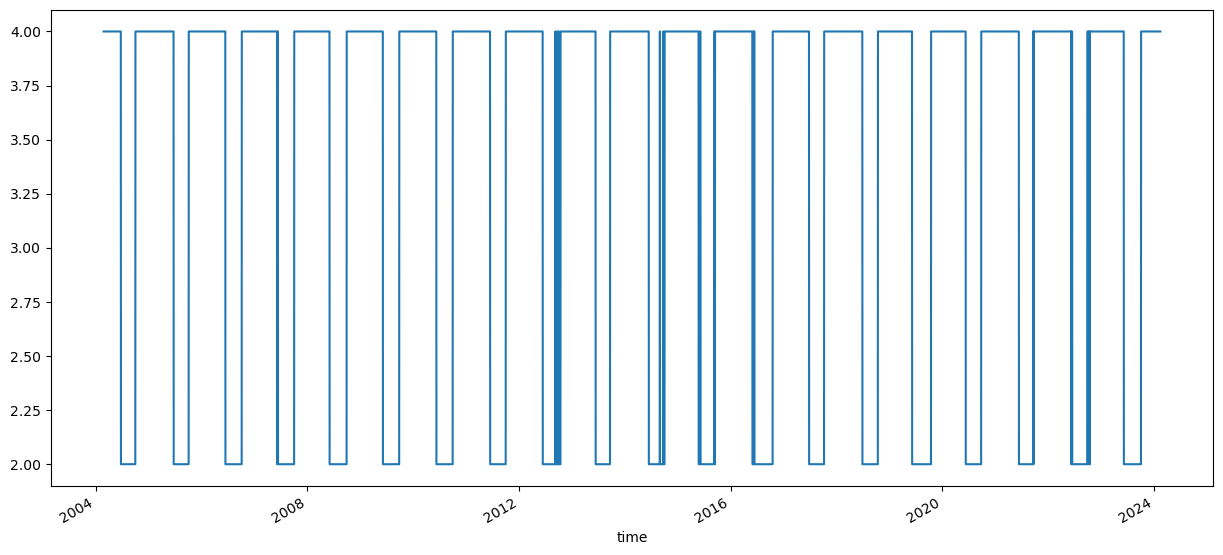

In [75]:
fig, ax = plt.subplots(figsize=(15, 7))
df_all['PALP'].plot(ax=ax)